<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 1 Sprint 3 Assignment 1*

# Apply the t-test to real data

Your assignment is to determine which issues have "statistically significant" differences between political parties in this [1980s congressional voting data](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records). The data consists of 435 instances (one for each congressperson), a class (democrat or republican), and 16 binary attributes (yes or no for voting for or against certain issues). Be aware - there are missing values!

Your goals:

1. Load and clean the data (or determine the best method to drop observations when running tests)
2. Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01
3. Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01
4. Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)

Note that this data will involve *2 sample* t-tests, because you're comparing averages across two groups (republicans and democrats) rather than a single group against a null hypothesis.

Stretch goals:

1. Refactor your code into functions so it's easy to rerun with arbitrary variables
2. Apply hypothesis testing to your personal project data (for the purposes of this notebook you can type a summary of the hypothesis you formed and tested)

In [0]:
#Quick import of our most commonly used libraries. In the case of seaborn, I just happen to like it.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel

In [2]:
#Loading the data and having a quick look, immediately confirming the warned missing values
column_names =['Class name', 'handicapped-infants', 'water-project', 
            'budget', 'physician-fee-freeze', 
            'el-salvador-aid', 'religious-groups-in-schools',
            'anti-satellite-test-ban', 'aid-to-nicaraguan-contras', 'mx-missile',
            'immigration', 'synfuels', 'education-spending',
            'superfund-right-to-sue', 'crime', 'duty-free-exports',
            'export-south-africa']
voting_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data',
                        header = None, names = column_names, na_values='?')
#After some looking, I figured out I'd completely forgotten to check the data
#description for the column names. I've since addressed that and go ahead and make
#?'s nan here in this first block
voting_df.head()

,Class name,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [4]:
#Now we have an accurate count of missing values by column
voting_df.isna().sum()

Class name                       0
handicapped-infants             12
water-project                   48
budget                          11
physician-fee-freeze            11
el-salvador-aid                 15
religious-groups-in-schools     11
anti-satellite-test-ban         14
aid-to-nicaraguan-contras       15
mx-missile                      22
immigration                      7
synfuels                        21
education-spending              31
superfund-right-to-sue          25
crime                           17
duty-free-exports               28
export-south-africa            104
dtype: int64

In [5]:
#Here we format our binary y/n responses to 1/0
voting_df.replace(('y', 'n'), (1,0), inplace=True)
voting_df.head()

,Class name,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
#Next, we'll grab an issue to compare, and split it by party
#I'm going to use immigration, as it has the fewest nan values
imm_r = voting_df[voting_df['Class name']=='republican']['immigration']
imm_d = voting_df[voting_df['Class name']=='democrat']['immigration']

In [8]:
#I struggled a lot trying to figure out a way to make a function that would
#Iterate over the columns and handle this one set at a time but just couldn't figure it out
#However, this does tell us that the very first issue, doesn't have much difference either way
stat, pvalue = ttest_ind(imm_r,imm_d,nan_policy='omit')
print(stat, pvalue)
#With such a high pvalue, we fail to reject our null hypothesis that these two
#groups have different means, concluding they're both responding in a similar way

1.7359117329695164 0.08330248490425066


In [0]:
#Let's try another issue, infants this time, since it's our next lowest nan count
infants_r = voting_df[voting_df['Class name']=='republican']['handicapped-infants']
infants_d = voting_df[voting_df['Class name']=='democrat']['handicapped-infants']

In [10]:
stat, pvalue = ttest_ind(infants_r,infants_d,nan_policy='omit')
print(stat, pvalue)
#On this issue, we notice an extremely low pvalue, concluding that dems and reps
#have different means, and thus are split on this issue

-9.205264294809222 1.613440327937243e-18


In [0]:
#Now I'm dropping the na values entirely to plot them, one of the reasons I chose
#the columns with the least na's. The plot will help us understand which side is
#for and which is against
infants_r.dropna()
infants_d.dropna()

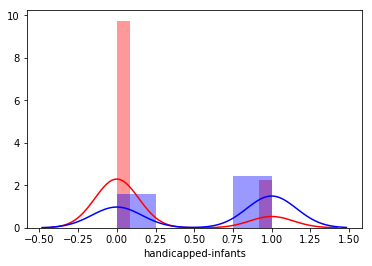

In [16]:
#From this plot, we can see that while dems seem a little split, leaning towards
#support on the issue reps are absolutely against it
sns.distplot(infants_r,color='r')
sns.distplot(infants_d,color='b')


In [0]:
#Exploring other issues to see if we can find a reverse of the first
r_in_school_rep = voting_df[voting_df['Class name']=='republican']['religious-groups-in-schools']
r_in_school_dem = voting_df[voting_df['Class name']=='democrat']['religious-groups-in-schools']

In [18]:
stat, pvalue = ttest_ind(r_in_school_rep,r_in_school_dem,nan_policy='omit')
print(stat, pvalue)

9.737575825219457 2.3936722520597287e-20


In [0]:
#Wonderful! Another low pvalue allowing us to reject our null hypothesis
#Let's lose those na values
r_in_school_dem = r_in_school_dem.dropna()
r_in_school_rep = r_in_school_rep.dropna()

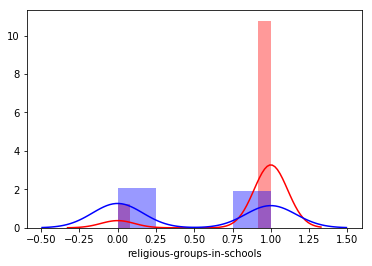

In [24]:
#Lot's plot them again and have a look at the split
sns.distplot(r_in_school_rep,color='r')
sns.distplot(r_in_school_dem,color='b')
#In the case of this plot we can see that once again, the main split is the reps
#This time however, they're in support of it